In [1]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
!dir

DAMLAS-HW03-Template-2016-07-22.ipynb  readme.md


In [1]:
!python --version

Python 2.7.12 :: Continuum Analytics, Inc.


In [5]:
import os

for key, value in os.environ.items():
    print(key, value)

('APACHE_SPARK_VERSION', '1.6.1')
('R_LIBS_USER', '/usr/local/spark/R/lib')
('MESOS_NATIVE_LIBRARY', '/usr/local/lib/libmesos.so')
('SPARK_HOME', '/usr/local/spark')
('PATH', '/opt/conda/envs/python2/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin')
('HOME', '/home/jovyan')
('PS1', '(python2) ')
('LANG', 'en_US.UTF-8')
('TERM', 'xterm-color')
('SHELL', '/bin/bash')
('LANGUAGE', 'en_US.UTF-8')
('SHLVL', '1')
('CONDA_PREFIX', '/opt/conda/envs/python2')
('CONDA_PS1_BACKUP', '')
('CONDA_DEFAULT_ENV', 'python2')
('DEBIAN_FRONTEND', 'noninteractive')
('NB_UID', '1000')
('NB_USER', 'jovyan')
('JPY_PARENT_PID', '58')
('PYTHONPATH', '/usr/local/spark/python:/usr/local/spark/python/lib/py4j-0.9-src.zip')
('GIT_PAGER', 'cat')
('LC_ALL', 'en_US.UTF-8')
('_', '/opt/conda/envs/python2/bin/jupyter-notebook')
('CONDA_DIR', '/opt/conda')
('SPARK_OPTS', '--driver-java-options=-Xms1024M --driver-java-options=-Xmx4096M --driver-java-options=-Dlog4j.logLevel=info')
('HOSTNAM

# DAMLAS - Machine Learning At Scale
## Assignment - HW3
Data Analytics and Machine Learning at Scale
Target, Minneapolis

---
__Name:__  *Alfredo Marquez*   
__Class:__ DAMLAS (Section *Your Section Goes Here*, e.g., Summer 2016)     
__Email:__  *alfredo.marquez2*@Target.com     
__Week:__   03

# Table of Contents <a name="TOC"></a> 

1.  [HW Introduction](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
    3.0.  [Short Answer Questions](#HW3.0)    
    3.1.  [Word Count plus sorting](#HW3.1)   
    3.2.  [MLlib-centric Kmeans](#HW3.2)    
    3.3.  [Homegrown KMeans in Spark](#HW3.3)    
    3.4.  [Making Homegrown KMeans more efficient](#HW3.4)  
    3.5.  [OPTIONAL Weighted KMeans](#HW3.5)  
    3.6.  [OPTIONAL Linear Regression](#HW3.6)  
    3.7.  [OPTIONAL Error surfaces](#HW3.7)



<a name="1">
# 1 Instructions
[Back to Table of Contents](#TOC)
* Homework submissions are due by Tueday, 08/02/2016 at 11AM (CT).


* Prepare a single Jupyter note, please include questions, and question numbers in the questions and in the responses.
Submit your homework notebook via the following form:

   + [Submission Link - Google Form](http://goo.gl/forms/er3OFr5eCMWDngB72)


### Documents:
* IPython Notebook, published and viewable online.
* PDF export of IPython Notebook.
    
<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* Karau, Holden, Konwinski, Andy, Wendell, Patrick, & Zaharia, Matei. (2015). Learning Spark: Lightning-fast big data analysis. Sebastopol, CA: O’Reilly Publishers.
* Hastie, Trevor, Tibshirani, Robert, & Friedman, Jerome. (2009). The elements of statistical learning: Data mining, inference, and prediction (2nd ed.). Stanford, CA: Springer Science+Business Media. __(Download for free [here](http://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf))__
* Ryza, Sandy, Laserson, Uri, Owen, Sean, & Wills, Josh. (2015). Advanced analytics with Spark: Patterns for learning from data at scale. Sebastopol, CA: O’Reilly Publishers.
---
* [Slides for Supervised-ML-Classification-via-GradientDescent](https://www.dropbox.com/s/uzoch1dwft8kaqw/Lecture-15-Supervised-ML-Classification-via-GradientDescent.pdf?dl=0)
* [Slides from High Entropy Friday]( https://www.dropbox.com/s/0dlvsff3660vvbk/Lecture-High-Entropy-Friday.pdf?dl=0)

---

<a name="HW3">
# 3 HW Problems
[Back to Table of Contents](#TOC)

In [ ]:
# Initiate Spark on Local:  ** Do not run this on Docker **
import sys #current as of 9/26/2015

# spark_home = os.environ['SPARK_HOME'] = '/Users/jshanahan/Dropbox/Lectures-UC-Berkeley-ML-Class-2015/spark-1.6.1-bin-hadoop2.6/'
spark_home = os.environ['SPARK_HOME'] = 'C:\Apps\Apache\Spark-1.6.1'
if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.9-src.zip'))

# First, we initialize the Spark environment

#import findspark
#findspark.init()

import pyspark
from pyspark.sql import SQLContext

# We can give a name to our app (to find it in Spark WebUI) and configure execution mode
# In this case, it is local multicore execution with "local[*]"
app_name = "example-logs"
master = "local[*]"
conf = pyspark.SparkConf().setAppName(app_name).setMaster(master)
sc = pyspark.SparkContext(conf=conf)
sqlContext = SQLContext(sc)


print(sc)
print(sqlContext)


# Import some libraries to work with dates
import dateutil.parser
import dateutil.relativedelta as dateutil_rd

In [16]:
# Spark Initialization: Worked on old local spark install.
import os
import sys
#Escape L for line numbers
#spark_home = os.environ['SPARK_HOME'] = '/Users/liang/Downloads/spark-1.4.1-bin-hadoop2.6/'
#spark_home = os.environ['SPARK_HOME'] = '/Users/jshanahan/Dropbox/Lectures-UC-Berkeley-ML-Class-2015/spark-1.5.0-bin-hadoop2.6/'
#spark_home = os.environ['SPARK_HOME'] = '/Users/james.shanahan/Dropbox/Lectures-UC-Berkeley-ML-Class-2015/spark-1.5.0-bin-hadoop2.6/'
#spark_home = os.environ['SPARK_HOME'] = '/Users/liang/Downloads/spark-1.3.0-bin-hadoop2.4/'
#spark_home = os.environ['SPARK_HOME'] = 'C:\Apps\Apache\Spark-1.6.1'
spark_home = os.environ['SPARK_HOME'] = 'C:/Apps/Apache/Spark-1.6.1'
if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
#sys.path.insert(0,os.path.join(spark_home,'python'))
#sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
#execfile(os.path.join(spark_home,'python/pyspark/shell.py'))
#execfile(os.path.join(spark_home,'C:/Apps/Apache/Spark-1.6.1/bin/pyspark.py'))
execfile(os.path.join(spark_home,'/bin/pyspark.py'))

IOError: [Errno 2] No such file or directory: '/bin/pyspark.py'

In [2]:
# Spark Initialization: DOCKER 
import pyspark
from pyspark.sql import SQLContext

# We can give a name to our app (to find it in Spark WebUI) and configure execution mode
# In this case, it is local multicore execution with "local[*]"
app_name = "example-logs"
master = "local[*]"
conf = pyspark.SparkConf().setAppName(app_name).setMaster(master)
sc = pyspark.SparkContext(conf=conf)
sqlContext = SQLContext(sc)


print(sc)
print(sqlContext)


# Import some libraries to work with dates
import dateutil.parser
import dateutil.relativedelta as dateutil_rd

<a name="3.0"></a><h2 style="color:darkblue"> HW3.0: Short answer questions </h2>
[Back to Table of Contents](#TOC)


__What is Apache Spark and how is it different to Apache Hadoop? __

**Answer #1**
> "Apache Spark is a cluster computing platform desinged to be fast and gernal-purpose." (pg.1, Learning Spark).  The speed allows for interactive data analysis, and the general purpose allows for "a wide range of workloads that previously required separate dstiributd systems, icluding batch applications, iterative algorithms, interactive queries, and streaming. (pg.1 , Learning Spark).
Hadoop is a file distributed system that is designed for storing data.  API's can reach out to Hadoop to access and perform ETL on the data.  Map Reduce was the process for which to drive operations in hadoop, but Map Reduce was very inefficient and not as interactive as Spark. (pgs. 6-7, Learning Spark)

<hr> 

__Fill in the blanks:
Spark API consists of interfaces to develop applications based on it in Java, __Scala, Python__ languages (list languages). __

**Answer #2** 
>Scala, Python, SQL, and R. (pg.1 Learning Spark). 

<hr>

__Using Spark, resource management can be done either in a single server instance or using a framework such as Mesos or YARN in a distributed manner. __

**Answer #3** Spark's Stand Alone Scheduler, APACHE Mesos, HADOOP YARN for the cluster; Local for single server/machine.

<hr>

__What is an RDD and show a fun example of creating one and bringing the first element back to the driver program. __

**Answer #4: see below** From the Spark website.
>Resilient Distributed Datasets (RDDs)
"Spark revolves around the concept of a resilient distributed dataset (RDD), which is a fault-tolerant collection of elements that can be operated on in parallel. There are two ways to create RDDs: parallelizing an existing collection in your driver program, or referencing a dataset in an external storage system, such as a shared filesystem, HDFS, HBase, or any data source offering a Hadoop InputFormat."

<hr>


In [9]:
# Answer #4:
rdd20 = sc.parallelize(range(1,20,1))
rdd20.first()

1

<a name="HW3.1"> <h2 style="color:darkgreen">HW3.1 WordCount plus sorting </h2>
[Back to Table of Contents](#TOC)

The following notebooks will be useful to jumpstart this collection of Homework exercises:


* [Example Notebook with Debugging tactics in Spark](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/jqjllp8kmf1eolk/WordCountDebugging-Example.ipynb)
* [Word Count Quiz](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/vgmpivsi4rvqz0s/WordCountQuiz.ipynb)
* [Work Count Solution](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/dxv3dmp1vluuo8i/WordCountQuiz-Solution.ipynb)

---
In Spark write the code to count how often each word appears in a text document (or set of documents). Please use this homework document (with no solutions in it) as a the example document to run an experiment.  Report the following: 
* provide a sorted list of tokens in decreasing order of frequency of occurence limited to [top 20 most frequent only] and [bottom 10 least frequent]. 


__OPTIONAL__ 
Feel free to do a secondary sort where words with the same frequncy are sorted alphanumerically increasing. Plseas refer to the [following notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/uu5afr3ufpm9fy8/SecondarySort.ipynb)
 for examples of secondary sorts in Spark. Please provide the following [top 20 most frequent terms only] and [bottom 10 least frequent terms]

__NOTE__ [Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__

**Online References: http://stackoverflow.com/questions/30787635/takeordered-descending-pyspark
**

In [26]:
## Code goes here
data = sc.textFile('HW3.txt')
#data.take(10)
words = data.flatMap(lambda x: x.split(' ')) \
        .map(lambda word: (word, 1)) \
        .reduceByKey(lambda x,y: (x+y))

        
print ('Top 20 occurences:' , words.takeOrdered(20, key = lambda x: -x[1]) )
print ('Bottom 10 occurences:' , words.takeOrdered(10, key = lambda x: x[1]) )

('Top 20 occurences:', [(u'the', 71), (u'', 68), (u'of', 49), (u'and', 40), (u'to', 33), (u'in', 32), (u'##', 27), (u'a', 23), (u'this', 17), (u'Contents', 17), (u'Table', 17), (u'for', 17), (u'Back', 16), (u'with', 14), (u'as', 13), (u'&', 12), (u'data', 12), (u'KMeans', 12), (u'code', 11), (u'here', 11)])
('Bottom 10 occurences:', [(u'limited', 1), (u'forget', 1), (u'Here@Target.com', 1), (u'consists', 1), (u'inverse', 1), (u'terms', 1), (u'HW3.1', 1), (u'graph', 1), (u'HW3.7', 1), (u'HW3.6', 1)])


In [ ]:
## Drivers & Runners

In [ ]:
## Run Scripts, S3 Sync

<a name="HW3.1.1"><h2 style="color:darkgreen">HW3.1.1 </h2>
[Back to Table of Contents](#TOC)

Modify the above word count code to count words that begin with lower case letters (a-z) and report your findings. Again sort the output words in decreasing order of frequency.


In [28]:
## Code goes here
data = sc.textFile('HW3.txt')
#data.take(10)
words = data.flatMap(lambda x: x.split(' ')) \
        .filter(lambda x: x.isalpha() ) \
        .map(lambda word: (word, 1)) \
        .reduceByKey(lambda x,y: (x+y))

        
print ('Top 20 occurences:' , words.takeOrdered(20, key = lambda x: -x[1]) )
print ('Bottom 10 occurences:' , words.takeOrdered(10, key = lambda x: x[1]) )

('Top 20 occurences:', [(u'the', 71), (u'of', 49), (u'and', 40), (u'to', 33), (u'in', 32), (u'a', 23), (u'this', 17), (u'Contents', 17), (u'Table', 17), (u'for', 17), (u'Back', 16), (u'with', 14), (u'as', 13), (u'data', 12), (u'KMeans', 12), (u'code', 11), (u'here', 11), (u'model', 11), (u'plot', 10), (u'Run', 10)])
('Bottom 10 occurences:', [(u'sameModel', 1), (u'limited', 1), (u'forget', 1), (u'consists', 1), (u'inverse', 1), (u'graph', 1), (u'languages', 1), (u'include', 1), (u'stackoverflow', 1), (u'bringing', 1)])


In [ ]:
## Drivers & Runners

In [ ]:
## Run Scripts, S3 Sync

<a name="HW3.2"> <h2 style="color:darkblue"> HW3.2: MLlib-centric KMeans</h2>
[Back to Table of Contents](#TOC)

Using the following  MLlib-centric KMeans code snippet: 

<pre>
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt


# Load and parse the data
# NOTE  kmeans_data.txt is available here 
#          https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("kmeans_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,
        runs=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

# Save and load model
clusters.save(sc, "myModelPath")
sameModel = KMeansModel.load(sc, "myModelPath")

</pre>

__NOTE__ <p> The  __kmeans_data.txt__ is available here https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 

__TASKS__
* Run this code snippet and list the clusters that your find.
* compute the Within Set Sum of Squared Errors for the found clusters. Comment on your findings.

In [43]:
!cat kmeans_data.txt

0.0 0.0 0.0
0.1 0.1 0.1
0.2 0.2 0.2
9.0 9.0 9.0
9.1 9.1 9.1
9.2 9.2 9.2


In [49]:
## Code goes here
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt


# Load and parse the data
# NOTE  kmeans_data.txt is available here 
#          https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("kmeans_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))
print ('Points:' , parsedData.collect())

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,
        runs=10, initializationMode="random")
print ('Centers: ' , clusters.centers)
# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)] # predicts/classifies into cluster 1 or cluster 2
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

# Save and load model
#clusters.save(sc, "myModelPath")
#sameModel = KMeansModel.load(sc, "myModelPath")

('Points:', [array([ 0.,  0.,  0.]), array([ 0.1,  0.1,  0.1]), array([ 0.2,  0.2,  0.2]), array([ 9.,  9.,  9.]), array([ 9.1,  9.1,  9.1]), array([ 9.2,  9.2,  9.2])])
('Centers: ', [array([ 9.1,  9.1,  9.1]), array([ 0.1,  0.1,  0.1])])
Within Set Sum of Squared Error = 0.692820323028


In [ ]:
#recreated in R:
> (0.0 - 0.1)^2 + (0.0 - 0.1)^2  + (0.0 - 0.1)^2  
[1] 0.03
> sqrt(0.03)
[1] 0.1732051
> 0.1732051*4
[1] 0.6928204
> 

# the error turns out to be exactly the same for each point, 0.1732051, except for 2 where the error is 0.  
# because the difference between the points and the centers are so small, you get a small WSSSE.

In [ ]:
## Drivers & Runners

In [ ]:
## Run Scripts, S3 Sync

<a name="HW3.3"><h2 style="color:darkgreen"> HW3.3: Homegrown KMeans in Spark </h2>
[Back to Table of Contents](#TOC)

Download the following KMeans [notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb).

Generate 3 clusters with 100 (one hundred) data points per cluster (using the code provided). Plot the data.
Then run MLlib's Kmean implementation on this data  and report your results as follows:

* plot the resulting clusters after 1 iteration, 10 iterations, after 20 iterations, after 100 iterations.
* in each plot please report the Within Set Sum of Squared Errors for the found clusters (as part of the title WSSSE). Comment on the progress of this measure as  the KMEans algorithms runs for more iterations. 
* Then plot the WSSSE as a function of the iteration (1, 10, 20, 30, 40, 50, 100).

**Online References: 
http://spark.apache.org/docs/latest/mllib-clustering.html
**

In [42]:
## Code goes here
%matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 100
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data3_3.csv',data,delimiter = ',')

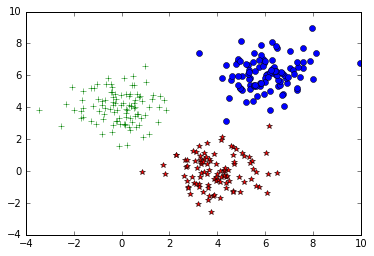

In [43]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
pylab.show()

In [73]:
import numpy as np

#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

('Iteration:', 1)


/usr/local/spark/python/pyspark/mllib/clustering.py:176: UserWarning: Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.
  "Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.")


('Centers: ', [array([ 3.99161955,  0.08749763]), array([ 5.07192652,  5.89846617]), array([-0.41258556,  3.78930352])])
Within Set Sum of Squared Error = 408.431946713


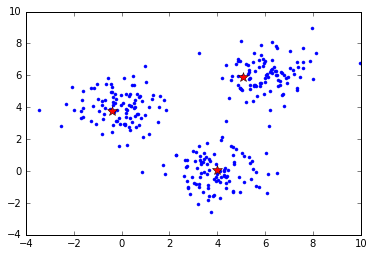

('Iteration:', 10)
('Centers: ', [array([ 6.07237948,  6.0868025 ]), array([-0.11205806,  4.01663716]), array([ 3.91966766, -0.01739399])])
Within Set Sum of Squared Error = 372.465278153


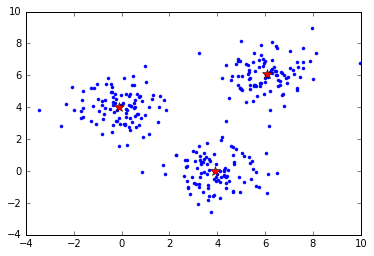

('Iteration:', 20)
('Centers: ', [array([ 3.91966766, -0.01739399]), array([ 6.07237948,  6.0868025 ]), array([-0.11205806,  4.01663716])])
Within Set Sum of Squared Error = 372.465278153


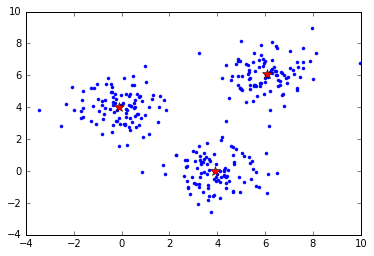

('Iteration:', 30)
('Centers: ', [array([-0.11205806,  4.01663716]), array([ 3.91966766, -0.01739399]), array([ 6.07237948,  6.0868025 ])])
Within Set Sum of Squared Error = 372.465278153


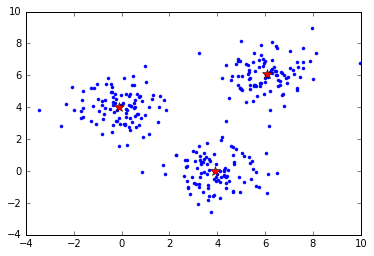

('Iteration:', 40)
('Centers: ', [array([ 6.07237948,  6.0868025 ]), array([-0.11205806,  4.01663716]), array([ 3.91966766, -0.01739399])])
Within Set Sum of Squared Error = 372.465278153


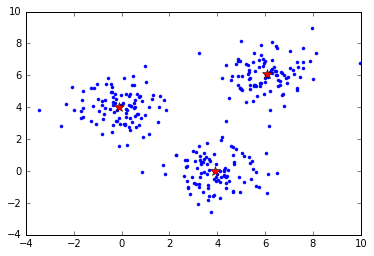

('Iteration:', 50)
('Centers: ', [array([ 3.91966766, -0.01739399]), array([-0.11205806,  4.01663716]), array([ 6.07237948,  6.0868025 ])])
Within Set Sum of Squared Error = 372.465278153


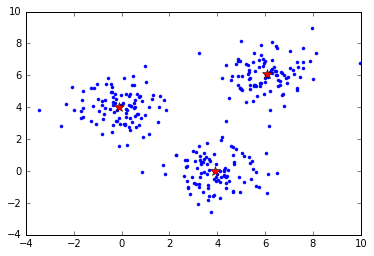

('Iteration:', 100)
('Centers: ', [array([ 6.07237948,  6.0868025 ]), array([-0.11205806,  4.01663716]), array([ 3.91966766, -0.01739399])])
Within Set Sum of Squared Error = 372.465278153


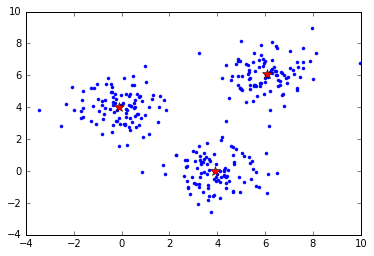

('ScreePlot Data:', {1: 408.4319467127224, 100: 372.4652781527718, 40: 372.4652781527718, 10: 372.4652781527718, 50: 372.4652781527718, 20: 372.4652781527718, 30: 372.4652781527718})


In [49]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt


# Load and parse the data
# NOTE  kmeans_data.txt is available here 
#          https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("data3_3.csv")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(',')]))
#print ('Points:' , parsedData.collect())

ScreePlot = {}
for i in (1,10,20,30,40,50,100) : 
    print ("Iteration:" , i)
    # Build the model (cluster the data)
    clusters = KMeans.train(parsedData, 3, maxIterations=i,
            runs=10, initializationMode="random")

    print ('Centers: ' , clusters.centers)

    # Evaluate clustering by computing Within Set Sum of Squared Errors
    def error(point):
        center = clusters.centers[clusters.predict(point)] # predicts/classifies into cluster 1 or cluster 2
        return sqrt(sum([x**2 for x in (point - center)]))

    WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    ScreePlot[i]= WSSSE
    print("Within Set Sum of Squared Error = " + str(WSSSE))
    plot_iteration(clusters.centers)

print ('ScreePlot Data:' , ScreePlot)

# Save and load model
#clusters.save(sc, "myModelPath3_3")
#sameModel = KMeansModel.load(sc, "myModelPath3_3")

[1, 408.4319467127224]
[100, 372.4652781527718]
[40, 372.4652781527718]
[10, 372.4652781527718]
[50, 372.4652781527718]
[20, 372.4652781527718]
[30, 372.4652781527718]
[1, 100, 40, 10, 50, 20, 30]
[408.4319467127224, 372.4652781527718, 372.4652781527718, 372.4652781527718, 372.4652781527718, 372.4652781527718, 372.4652781527718]


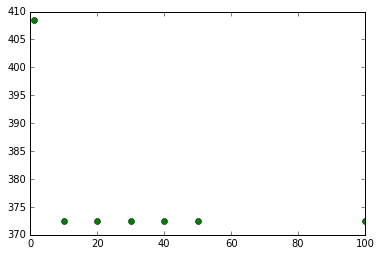

In [50]:
Iterations = []
WSSSE_list = []
for key, value in ScreePlot.items():
    Iterations.append(key)
    WSSSE_list.append(value)
    print [key, value]

print Iterations
print WSSSE_list
pylab.plot(Iterations, WSSSE_list,'o',color = 'green')
pylab.show()

# Answer:
> The WSSSE drops quick between the 1st and 10th iteration, then elbows, then it remains stable or flat as the more iterations
are conducted.  For a dataset this small one would expect convergence to rather quickly, but data sets at scale may take many more
iterations to converge.

In [ ]:
## Drivers & Runners

In [ ]:
## Run Scripts, S3 Sync

<a name="HW3.4"><h2 style="color:darkblue"> HW3.4: KMeans Experiments  </h2>
[Back to Table of Contents](#TOC)

Using this provided [homegrown Kmeans code](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb)   repeat the experiments in HW3.3. Explain any differences between the results in HW3.3 and HW3.4. 

In [60]:
## Code goes here

centroidsnew:
[[0, array([ 0.79596844,  0.68609998])], [1, array([ 4.01474397,  2.69914556])], [2, array([ 1.90033532,  5.6615767 ])]]
centroidrdd:
[array([ 0.79596844,  0.68609998]), array([ 4.01474397,  2.69914556]), array([ 1.90033532,  5.6615767 ])]
WSSSE_pts
(0, (array([-0.81098336,  2.35304528]), array([ 0.79596844,  0.68609998])))
WSSSE_sum:
976.000748794
('ScreePlot:', {0: 976.0007487938594})
Iteration0
[[ 0.79596844  0.68609998]
 [ 4.01474397  2.69914556]
 [ 1.90033532  5.6615767 ]]


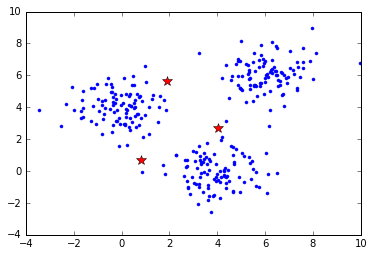

Within Set Sum of Squared Error = 976.000748794


Next Iteration:
centroidsnew:
[[0, array([ 1.39296223,  1.07884152])], [1, array([ 5.35578926,  2.9599148 ])], [2, array([ 1.88791271,  5.33642902])]]
centroidrdd:
[array([ 1.39296223,  1.07884152]), array([ 5.35578926,  2.9599148 ]), array([ 1.88791271,  5.33642902])]
WSSSE_pts
(0, (array([ 3.09170799, -0.84372778]), array([ 1.39296223,  1.07884152])))
WSSSE_sum:
850.277425833
('ScreePlot:', {0: 976.0007487938594, 1: 850.2774258331406})
Iteration1
[[ 1.39296223  1.07884152]
 [ 5.35578926  2.9599148 ]
 [ 1.88791271  5.33642902]]


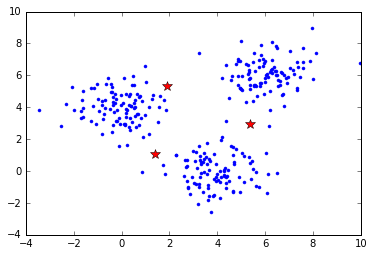

Within Set Sum of Squared Error = 850.277425833


Next Iteration:
centroidsnew:
[[0, array([ 2.41618042,  0.63253809])], [1, array([ 5.95285144,  4.52526253])], [2, array([ 0.76592312,  4.89897291])]]
centroidrdd:
[array([ 2.41618042,  0.63253809]), array([ 5.95285144,  4.52526253]), array([ 0.76592312,  4.89897291])]
WSSSE_pts
(0, (array([ 3.09170799, -0.84372778]), array([ 2.41618042,  0.63253809])))
WSSSE_sum:
652.891972675
('ScreePlot:', {0: 976.0007487938594, 1: 850.2774258331406, 2: 652.8919726745921})
Iteration2
[[ 2.41618042  0.63253809]
 [ 5.95285144  4.52526253]
 [ 0.76592312  4.89897291]]


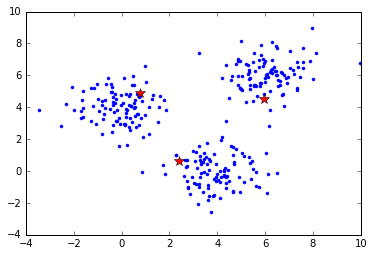

Within Set Sum of Squared Error = 652.891972675


Next Iteration:
centroidsnew:
[[0, array([ 3.76196259,  0.01593953])], [1, array([ 6.08317096,  5.99602619])], [2, array([-0.1043458 ,  4.13793907])]]
centroidrdd:
[array([ 3.76196259,  0.01593953]), array([ 6.08317096,  5.99602619]), array([-0.1043458 ,  4.13793907])]
WSSSE_pts
(0, (array([ 3.09170799, -0.84372778]), array([ 3.76196259,  0.01593953])))
WSSSE_sum:
383.100375952
('ScreePlot:', {0: 976.0007487938594, 1: 850.2774258331406, 2: 652.8919726745921, 3: 383.1003759516303})
Iteration3
[[ 3.76196259  0.01593953]
 [ 6.08317096  5.99602619]
 [-0.1043458   4.13793907]]


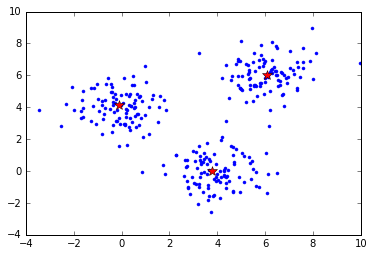

Within Set Sum of Squared Error = 383.100375952


Next Iteration:
centroidsnew:
[[0, array([ 3.91966766, -0.01739399])], [1, array([ 6.07237948,  6.0868025 ])], [2, array([-0.11205806,  4.01663716])]]
centroidrdd:
[array([ 3.91966766, -0.01739399]), array([ 6.07237948,  6.0868025 ]), array([-0.11205806,  4.01663716])]
WSSSE_pts
(0, (array([ 3.09170799, -0.84372778]), array([ 3.91966766, -0.01739399])))
WSSSE_sum:
372.465278153
('ScreePlot:', {0: 976.0007487938594, 1: 850.2774258331406, 2: 652.8919726745921, 3: 383.1003759516303, 4: 372.46527815277193})
Iteration4
[[ 3.91966766 -0.01739399]
 [ 6.07237948  6.0868025 ]
 [-0.11205806  4.01663716]]


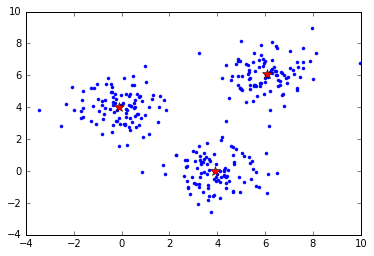

Within Set Sum of Squared Error = 372.465278153


Next Iteration:
Final Results:
[[ 3.91966766 -0.01739399]
 [ 6.07237948  6.0868025 ]
 [-0.11205806  4.01663716]]


In [75]:
import numpy as np
from numpy import array
from math import sqrt
import pylab 

K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("./data3_3.csv").cache()
iter_num = 0
ScreePlot = {}
for i in (range(10)): 
    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    #print ('res:')
    #print (res)
    
    #res [(0, (array([  2.66546663e+00,   3.94844436e+03]), 1001)  ), 
    #     (2, (array([ 6023.84995923,  5975.48511018]), 1000)), 
    #     (1, (array([ 3986.85984761,    15.93153464]), 999))]
    # res[1][1] returns 1000 here
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    #print (res[0] , centroids_new)
    if np.sum(np.absolute(centroids_new-centroids))<0.005:
        break
    
    centroidsnew = []
    for j in range(3):
        centroidsnew.append([j ,centroids_new[j]])
    
    #centroidsnew = dict(centroidsnew)
    print ("centroidsnew:")
    print centroidsnew
    centroidrdd = sc.parallelize(centroidsnew)
    print ("centroidrdd:")
    print centroidrdd.values().collect()
    
#     WSSSE_pts = D.map(nearest_centroid).collect()
#     #print ('WSSSE:' , WSSSE)
    
#     for i, j in WSSSE_pts[:5]:
#         print i, j 

  

            # Evaluate clustering by computing Within Set Sum of Squared Errors
    def error(point):
        center = point[1][1]
        points = point[1][0]
        diff = point[1][0]-point[1][1]
        #return points, center, diff
        #return np.substract(point , center)
        #center = clusters.centers[clusters.predict(point)] # centroids_new # predicts/classifies into cluster 1 or cluster 2
        return sqrt(sum([x**2 for x in (point[1][0]-point[1][1])]))
        
    WSSSE_pts = D.map(nearest_centroid) \
                .map(lambda x: (x[0], (x[1][0]))) \
                .join(centroidrdd) \
                .sortByKey() \
                .persist() \
                #.collectAsMap()
    
    print ("WSSSE_pts")
    print WSSSE_pts.first()
    #print WSSSE_pts.mapValues(lambda point: error(point)).collectAsMap()
    
#     WSSSE_sum = WSSSE_pts.map(lambda x: (x[0], (sum(x[1][0] - x[1][1])**2))) \
#                          #.reduceByKey(lambda x,y: (x + y))
    WSSSE = WSSSE_pts.map(lambda x: error(x)).reduce(lambda x, y: x + y)   
    print ('WSSSE_sum:')
    print WSSSE
    
    ScreePlot[i]= WSSSE
    print ('ScreePlot:' , ScreePlot)

    #plot_iteration(clusters.centers)
    
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1 
    centroids = centroids_new
    print centroids
    plot_iteration(centroids)
    print("Within Set Sum of Squared Error = " + str(WSSSE))
    print '\n'
    print 'Next Iteration:'
    
print "Final Results:"
print centroids

In [ ]:
## ('Centers: ', [array([ 6.07237948,  6.0868025 ]), array([-0.11205806,  4.01663716]), array([ 3.91966766, -0.01739399])])

[0, 976.0007487938594]
[1, 850.2774258331406]
[2, 652.8919726745921]
[3, 383.1003759516303]
[4, 372.46527815277193]
[0, 1, 2, 3, 4]
[976.0007487938594, 850.2774258331406, 652.8919726745921, 383.1003759516303, 372.46527815277193]


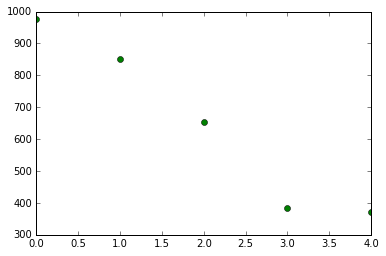

In [56]:
Iterations = []
WSSSE_list = []
for key, value in ScreePlot.items():
    Iterations.append(key)
    WSSSE_list.append(value)
    print [key, value]

print Iterations
print WSSSE_list
pylab.plot(Iterations, WSSSE_list,'o',color = 'green')
pylab.show()

# Answer :
> The first difference is that you can clearly see that the K-means algoritm converges in the 4th iteration.  This was our 
expectatoin from the previous experiment.  Also, you can see the WSSSE decreasing with each iteration very clearly, while in the 
previous example you only saw the drop from the first iteration to the 10th.
Finally, the end resuls are exactly the same down to many decimal points, or extreme precision.

In [ ]:
## Drivers & Runners

In [ ]:
## Run Scripts, S3 Sync

<a name="HW3.4.1"><h2 style="color:darkblue"> HW3.4.1: Making Homegrown KMeans more efficient  </h2>
[Back to Table of Contents](#TOC)

The above provided homegrown KMeans implentation in not the most efficient. How can you make it more efficient? Make this change in the code and show it work and comment on the gains you achieve. 

### HINT: have a look at  [this linear regression notebook](    http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb)

broadcast centroids:
[[ 0.  0.]
 [ 2.  2.]
 [ 0.  7.]]
centroidsnew:
[[0, array([ 0.79596844,  0.68609998])], [1, array([ 4.01474397,  2.69914556])], [2, array([ 1.90033532,  5.6615767 ])]]
centroidrdd:
[array([ 0.79596844,  0.68609998]), array([ 4.01474397,  2.69914556]), array([ 1.90033532,  5.6615767 ])]
WSSSE_pts
(0, (array([-0.81098336,  2.35304528]), array([ 0.79596844,  0.68609998])))
WSSSE_sum:
976.000748794
('ScreePlot:', {0: 976.0007487938594})
Iteration0
[[ 0.79596844  0.68609998]
 [ 4.01474397  2.69914556]
 [ 1.90033532  5.6615767 ]]


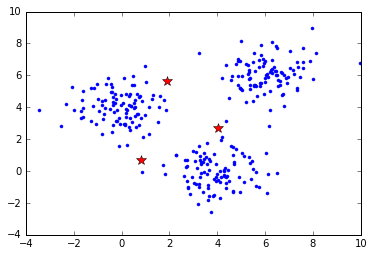

Within Set Sum of Squared Error = 976.000748794


Next Iteration:
broadcast centroids:
[[ 0.79596844  0.68609998]
 [ 4.01474397  2.69914556]
 [ 1.90033532  5.6615767 ]]
centroidsnew:
[[0, array([ 1.39296223,  1.07884152])], [1, array([ 5.35578926,  2.9599148 ])], [2, array([ 1.88791271,  5.33642902])]]
centroidrdd:
[array([ 1.39296223,  1.07884152]), array([ 5.35578926,  2.9599148 ]), array([ 1.88791271,  5.33642902])]
WSSSE_pts
(0, (array([ 3.09170799, -0.84372778]), array([ 1.39296223,  1.07884152])))
WSSSE_sum:
850.277425833
('ScreePlot:', {0: 976.0007487938594, 1: 850.2774258331406})
Iteration1
[[ 1.39296223  1.07884152]
 [ 5.35578926  2.9599148 ]
 [ 1.88791271  5.33642902]]


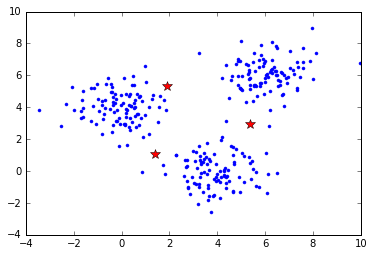

Within Set Sum of Squared Error = 850.277425833


Next Iteration:
broadcast centroids:
[[ 1.39296223  1.07884152]
 [ 5.35578926  2.9599148 ]
 [ 1.88791271  5.33642902]]
centroidsnew:
[[0, array([ 2.41618042,  0.63253809])], [1, array([ 5.95285144,  4.52526253])], [2, array([ 0.76592312,  4.89897291])]]
centroidrdd:
[array([ 2.41618042,  0.63253809]), array([ 5.95285144,  4.52526253]), array([ 0.76592312,  4.89897291])]
WSSSE_pts
(0, (array([ 3.09170799, -0.84372778]), array([ 2.41618042,  0.63253809])))
WSSSE_sum:
652.891972675
('ScreePlot:', {0: 976.0007487938594, 1: 850.2774258331406, 2: 652.8919726745921})
Iteration2
[[ 2.41618042  0.63253809]
 [ 5.95285144  4.52526253]
 [ 0.76592312  4.89897291]]


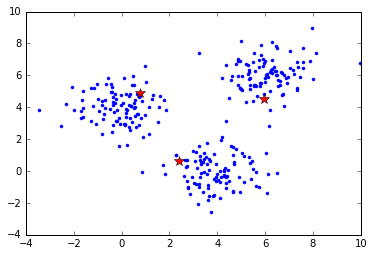

Within Set Sum of Squared Error = 652.891972675


Next Iteration:
broadcast centroids:
[[ 2.41618042  0.63253809]
 [ 5.95285144  4.52526253]
 [ 0.76592312  4.89897291]]
centroidsnew:
[[0, array([ 3.76196259,  0.01593953])], [1, array([ 6.08317096,  5.99602619])], [2, array([-0.1043458 ,  4.13793907])]]
centroidrdd:
[array([ 3.76196259,  0.01593953]), array([ 6.08317096,  5.99602619]), array([-0.1043458 ,  4.13793907])]
WSSSE_pts
(0, (array([ 3.09170799, -0.84372778]), array([ 3.76196259,  0.01593953])))
WSSSE_sum:
383.100375952
('ScreePlot:', {0: 976.0007487938594, 1: 850.2774258331406, 2: 652.8919726745921, 3: 383.1003759516303})
Iteration3
[[ 3.76196259  0.01593953]
 [ 6.08317096  5.99602619]
 [-0.1043458   4.13793907]]


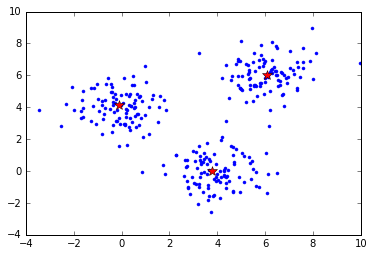

Within Set Sum of Squared Error = 383.100375952


Next Iteration:
broadcast centroids:
[[ 3.76196259  0.01593953]
 [ 6.08317096  5.99602619]
 [-0.1043458   4.13793907]]
centroidsnew:
[[0, array([ 3.91966766, -0.01739399])], [1, array([ 6.07237948,  6.0868025 ])], [2, array([-0.11205806,  4.01663716])]]
centroidrdd:
[array([ 3.91966766, -0.01739399]), array([ 6.07237948,  6.0868025 ]), array([-0.11205806,  4.01663716])]
WSSSE_pts
(0, (array([ 3.09170799, -0.84372778]), array([ 3.91966766, -0.01739399])))
WSSSE_sum:
372.465278153
('ScreePlot:', {0: 976.0007487938594, 1: 850.2774258331406, 2: 652.8919726745921, 3: 383.1003759516303, 4: 372.46527815277193})
Iteration4
[[ 3.91966766 -0.01739399]
 [ 6.07237948  6.0868025 ]
 [-0.11205806  4.01663716]]


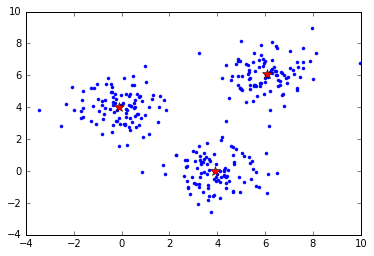

Within Set Sum of Squared Error = 372.465278153


Next Iteration:
broadcast centroids:
[[ 3.91966766 -0.01739399]
 [ 6.07237948  6.0868025 ]
 [-0.11205806  4.01663716]]
Final Results:
[[ 3.91966766 -0.01739399]
 [ 6.07237948  6.0868025 ]
 [-0.11205806  4.01663716]]


In [78]:
## Code goes here
import numpy as np
from numpy import array
from math import sqrt
import pylab 

K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])
#centroids = sc.broadcast(centroids)
D = sc.textFile("./data3_3.csv").cache()
iter_num = 0
ScreePlot = {}
for i in (range(10)):
    centroids = sc.broadcast(centroids)
    centroids = centroids.value
    print ('broadcast centroids:')
    print centroids
    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    #print ('res:')
    #print (res)
    
    #res [(0, (array([  2.66546663e+00,   3.94844436e+03]), 1001)  ), 
    #     (2, (array([ 6023.84995923,  5975.48511018]), 1000)), 
    #     (1, (array([ 3986.85984761,    15.93153464]), 999))]
    # res[1][1] returns 1000 here
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    #print (res[0] , centroids_new)
    if np.sum(np.absolute(centroids_new-centroids))<0.005:
        break
    
    centroidsnew = []
    for j in range(3):
        centroidsnew.append([j ,centroids_new[j]])
    
    #centroidsnew = dict(centroidsnew)
    print ("centroidsnew:")
    print centroidsnew
    centroidrdd = sc.parallelize(centroidsnew)
    print ("centroidrdd:")
    print centroidrdd.values().collect()
    
#     WSSSE_pts = D.map(nearest_centroid).collect()
#     #print ('WSSSE:' , WSSSE)
    
#     for i, j in WSSSE_pts[:5]:
#         print i, j 

  

            # Evaluate clustering by computing Within Set Sum of Squared Errors
    def error(point):
        center = point[1][1]
        points = point[1][0]
        diff = point[1][0]-point[1][1]
        #return points, center, diff
        #return np.substract(point , center)
        #center = clusters.centers[clusters.predict(point)] # centroids_new # predicts/classifies into cluster 1 or cluster 2
        return sqrt(sum([x**2 for x in (point[1][0]-point[1][1])]))
        
    WSSSE_pts = D.map(nearest_centroid) \
                .map(lambda x: (x[0], (x[1][0]))) \
                .join(centroidrdd) \
                .sortByKey() \
                .persist() \
                #.collectAsMap()
    
    print ("WSSSE_pts")
    print WSSSE_pts.first()
    #print WSSSE_pts.mapValues(lambda point: error(point)).collectAsMap()
    
#     WSSSE_sum = WSSSE_pts.map(lambda x: (x[0], (sum(x[1][0] - x[1][1])**2))) \
#                          #.reduceByKey(lambda x,y: (x + y))
    WSSSE = WSSSE_pts.map(lambda x: error(x)).reduce(lambda x, y: x + y)   
    print ('WSSSE_sum:')
    print WSSSE
    
    ScreePlot[i]= WSSSE
    print ('ScreePlot:' , ScreePlot)

    #plot_iteration(clusters.centers)
    
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1 
    centroids = centroids_new
    print centroids
    plot_iteration(centroids)
    print("Within Set Sum of Squared Error = " + str(WSSSE))
    print '\n'
    print 'Next Iteration:'
    
print "Final Results:"
print centroids

[0, 976.0007487938594]
[1, 850.2774258331406]
[2, 652.8919726745921]
[3, 383.1003759516303]
[4, 372.46527815277193]
[0, 1, 2, 3, 4]
[976.0007487938594, 850.2774258331406, 652.8919726745921, 383.1003759516303, 372.46527815277193]


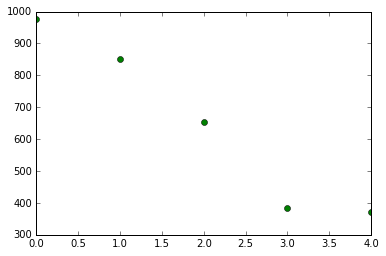

In [79]:
Iterations = []
WSSSE_list = []
for key, value in ScreePlot.items():
    Iterations.append(key)
    WSSSE_list.append(value)
    print [key, value]

print Iterations
print WSSSE_list
pylab.plot(Iterations, WSSSE_list,'o',color = 'green')
pylab.show()

# Answer:
> We can make it more efficient by broadcasting the cluster centers to the executors. 
I could not determine any differences from using the sc.broadcast() vs. not using them. The answers/outcomes remained the same.  
I can see a case when there dozens of clusters where it would be more beneficial to broadcasts the cluster centers across 
the executors.

In [ ]:
## Drivers & Runners

In [ ]:
## Run Scripts, S3 Sync

<a name="HW3.5"><h2 style="color:darkgreen"> HW3.5: OPTIONAL Weighted KMeans  </h2>
[Back to Table of Contents](#TOC)

Using this provided [homegrown Kmeans code](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb), modify it to do a weighted KMeans and repeat the experiements in HW3.3. Explain  any differences between the results in HW3.3 and HW3.5.

NOTE: Weight each example as follows using the inverse vector length (Euclidean norm): 

> weight(X)= 1/||X||, 

where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

Here X is vector made up of two values X1 and X2.

__[Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__

In [ ]:
## Code goes here

In [ ]:
## Drivers & Runners

In [ ]:
## Run Scripts, S3 Sync

<a name="HW3.6"><h2 style="color:darkblue"> HW3.6 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)
<a name="HW3.6.1"><h2 style="color:darkblue"> HW3.6.1 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)

Using [this linear regression notebook](    http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb):


* Generate 2 sets of data with 100 data points using the data generation code provided and plot each in separate plots. Call one the training set and the other the testing set.

* Using MLLib's LinearRegressionWithSGD train up a linear regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the linear regression model? Justify with plots (e.g., plot MSE as a function of the number of iterations) and words. 


<a name="HW3.6.2"><h2 style="color:darkblue"> HW3.6.2 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)

In the notebook provided above, in the cell labeled "Gradient descent (regularization)".

* Fill in the blanks and get this code to work for LASS0 and RIDGE linear regression.

* Using the data from 3.6.1 tune the hyper parameters of your LASS0 and RIDGE regression. Report your findings with words and plots.

In [ ]:
## Code goes here

In [ ]:
## Drivers & Runners

In [ ]:
## Run Scripts, S3 Sync

<a name="HW3.7"><h2 style="color:darkgreen"> HW3.7 OPTIONAL Error surfaces </h2>
[Back to Table of Contents](#TOC)

Here is a link to R code with 1 test drivers that plots the linear regression model in  model space and in the domain space:

> https://www.dropbox.com/s/3xc3kwda6d254l5/PlotModelAndDomainSpaces.R?dl=0

Here is a sample output from this script: 
      
> https://www.dropbox.com/s/my3tnhxx7fr5qs0/image%20%281%29.png?dl=0

Please use this as inspiration and code a equivalent error surface and heatmap (with isolines) in Spark and show the trajectory of learning taken during gradient descent(after each n-iterations of Gradient Descent):


Using Spark and  Python (using the above R Script as inspiration), plot the error surface for the linear regression model using a heatmap and contour plot. 
Also plot the current model in the original domain space for every 10th iteration.  Plot them side by side if possible  for each iteration: lefthand side plot is the model space(w0 and w01) and the righthand side plot is domain space (plot the corresponding model and training data in the problem domain space) with a final pair of graphs showing the entire trajectory in the model and domain space. Make sure to label your plots with iteration numbers, function, model space versus original domain space, MSE on the training data etc.

Also plot the MSE as a function of each iteration (possibly every 10th iteration). Dont forget to label both axis and the graph also. __[Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__





In [ ]:
## Code goes here

In [ ]:
## Drivers & Runners

In [ ]:
## Run Scripts, S3 Sync

[Back to Table of Contents](#TOC)
<center><div class='jumbotron'><h2 style='color:green'>-------  END OF HWK 9 --------</h2></div></center>